# Load data

In [301]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import sys
sys.path.append("..")
from scem import ebm, stein, kernel, util, gen
from scem.datasets import *
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm

In [303]:
dname = "banana"
p = load_data(dname, D=2, noise_std = 0.0, seed=0, itanh=False, whiten=False )

x = p.sample(1000)
x_eval = p.sample(100)

In [500]:
import torch 
import torch.nn as nn
import numpy as np
import torch.distributions as td


class EBM(nn.Module):
    
    '''
    EBM 
    '''
    
    def __init__(self, Dx, Dz, Dh):
        
        super().__init__()
        
        self.layer_1 = nn.Sequential(nn.Linear(Dx, Dh), nn.ELU(), nn.Linear(Dh, Dz))
        self.W       = nn.Parameter(torch.randn(Dz,Dz) / 10.)
        self.Wx      = nn.Parameter(torch.randn(Dz,Dz) / 10.)
        self.b1      = nn.Parameter(torch.randn(Dz) / 10.)
        self.b2      = nn.Parameter(torch.randn(Dz) / 10.)
        self.c      = nn.Parameter(torch.randn(1))
    
    def forward(self, X, Z):

#         h  = self.layer_1(X)
        W  = self.W
        Wx = self.Wx @ self.Wx.T
        E  = -torch.einsum('ij,jk,ik->i', X, Wx, X) + \
             torch.einsum('ij,jk,ik->i', X, W, Z) + X @ self.b1 + Z @ self.b2 + self.c 
        
        E = E - ((X**2).sum(-1)/20 + (Z**2).sum(-1))
        
        return E

# dimensionality of model 
Dx = 2
Dz = 2
Dh = 100

lebm = ebm.LatentEBMAdapter(EBM(Dx, Dz, Dh), var_type_obs='continuous', var_type_latent='continuous')

In [501]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [502]:
X = torch.as_tensor(x, dtype=torch.float32)

In [503]:
# define kernel

# KSD kernel on x
med2_x = util.pt_meddistance(X)**2
#kx = kernel.KIMQ(b=-0.5, c=1, s2=med2)
med2_px = torch.tensor([med2_x], requires_grad=False)
base_kernel = kernel.BKGauss(med2_px)

class LinFeat(nn.Module):
    def __init__(self, Dx):
        super(LinFeat, self).__init__()
        self.scales = nn.Parameter(torch.zeros([1]))
    def forward(self, X):
        return X * (torch.exp(self.scales))
lin_feat = LinFeat(Dx)
feat = kernel.FuncFeatureMap(lin_feat, (Dx,), (Dx,))
k_px = kernel.KSTFuncCompose(base_kernel, feat)
k_px = kernel.KGauss(med2_px)

# KCSD kernel on x
med2_qx = torch.tensor([med2_x], requires_grad=True)
k_qx = kernel.KGauss(med2_qx)

# q(z|x)
# cs = gen.CSFactorisedGaussian(Dx, Dz, Dh)
cs = gen.Implicit(Dx, Dz, Dh)
# KCSD kernel on z 
Z = cs.sample(1, X)
Z = Z.squeeze(0)
med2_z = util.pt_meddistance(Z)**2
# med2_z = 1.0
med2_z = torch.tensor([med2_z], requires_grad=True)
# k_z = kernel.KIMQ(b=-0.5, c=1, s2=med2_z)
k_z = kernel.KGauss(med2_z)


# approximate score p(x)
approx_score = stein.ApproximateScore(
        lebm.score_joint_obs, cs)
approx_score.n_sample = 100

In [504]:
# optimizer settings
learning_rate_q = 1e-3
weight_decay_q =  0
optimizer_q = torch.optim.Adam(cs.parameters(), lr=learning_rate_q,
                               weight_decay=weight_decay_q)


# optimizer settings for p(x)
learning_rate_p = 1e-3
weight_decay_p  = 0
optimizer_p = torch.optim.Adam(lebm.parameters(), lr=learning_rate_p,
                               weight_decay=weight_decay_p)

optimizer_med2_qx = torch.optim.Adam([med2_qx], lr=learning_rate_q,
                               weight_decay=weight_decay_q)

# optimizer_med2_px = torch.optim.Adam(lin_feat.parameters(), lr=learning_rate_p,
#                                weight_decay=weight_decay_p)

optimizer_med2_px = torch.optim.Adam([med2_px], lr=learning_rate_p,
                               weight_decay=weight_decay_p)

optimizer_med2_z = torch.optim.Adam([med2_z], lr=learning_rate_q,
                               weight_decay=weight_decay_q)

In [505]:
iter_p = 2000
iter_q = 10
batch_size = 100

In [506]:
def inner_loop(niter, X, cs):
    for i in range(niter):
        Z = cs.sample(1, X)
        Z = Z.squeeze(0)
        
        loss = stein.kcsd_ustat(
            X, Z, lebm.score_joint_latent, k_qx, k_z)
        
        optimizer_q.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_q.step()
        
#         Z = cs.sample(1, X)
#         Z = Z.squeeze(0)
#         loss = -stein.kcsd_ustat(
#             X, Z, lebm.score_joint_latent, k_qx, k_z)
        
#         optimizer_med2_qx.zero_grad()
#         optimizer_med2_z.zero_grad()
#         loss.backward(retain_graph=False)
#         optimizer_med2_qx.step()
#         optimizer_med2_z.step()
losses = []
med2s = []

In [ ]:
with tqdm.tqdm(range(50000)) as ts:
    for t in ts:

        # sample data
        perm = torch.randperm(X.shape[0]).detach()
        idx = perm[:batch_size]
        X_ = X[idx].detach()

        # train recognition model and KCSD kernels
        inner_loop(iter_q, X_, cs)
        
        loss = stein.ksd_ustat(X_, approx_score, k_px)  
        losses += [loss.item()]
        med2s  += [med2_px.item(), med2_qx.item(), med2_z.item()],
#         med2s  += [lin_feat.scales.exp().item()*med2_x, med2_qx.item(), med2_z.item()],
        ts.set_postfix(loss=loss.item())
    
        # train model p
        optimizer_p.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_p.step()
        
#         # train KSD kernel
#         perm = torch.randperm(X.shape[0]).detach()
#         idx = perm[:batch_size]
#         X_ = X[idx].detach()
        
#         loss = -stein.ksd_ustat(X_, approx_score, k_px)  
#         optimizer_med2_px.zero_grad()
#         loss.backward(retain_graph=False)
#         optimizer_med2_px.step()

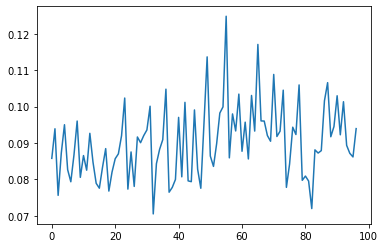

In [492]:
plt.plot(losses)

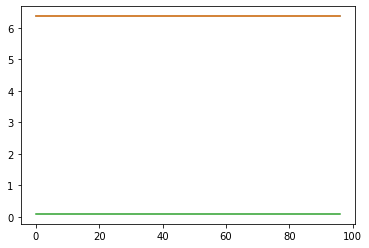

In [493]:
plt.plot(med2s)

In [494]:
# form a grid for numerical normalisation
from itertools import product
ngrid = 20
grid = torch.linspace(-10, 10, ngrid)
xz_eval = torch.tensor(list(product(*[grid]*4)))
x_eval = xz_eval[:,:2]
z_eval = xz_eval[:,2:]

In [495]:
# true log density
E_true = p.logpdf_multiple(torch.tensor(list(product(*[grid]*2))))
E_true -= E_true.max()

In [496]:
# EBM log density
E_eval = lebm(x_eval, z_eval).reshape(ngrid,ngrid,ngrid,ngrid).exp().detach()
E_eval /= E_eval.sum()
E_eval = E_eval.sum(-1).sum(-1)
E_eval.log_()
E_eval -= E_eval.max()
# E_eval = E_eval.sum(-1).sum(-1)

In [497]:
def normalise(E):
    if isinstance(E, np.ndarray):
        E = np.exp(E)
    else:
        E = E.exp()
    E /= E.sum()
    return E

(-10.0, 10.0)

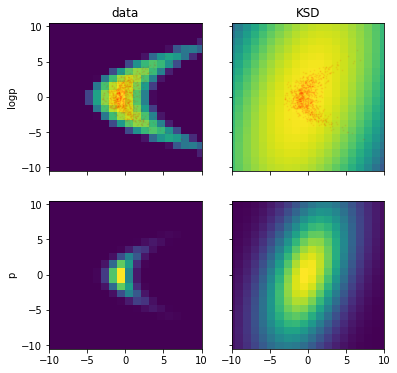

In [498]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)


ax = axes[0,0]
ax.pcolor(grid, grid,E_true.reshape(ngrid,ngrid), shading='auto', vmin=-10, vmax=0)
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,0]
ax.pcolor(grid, grid,normalise(E_true).reshape(ngrid,ngrid), shading='auto')

ax = axes[0,1]
ax.pcolor(grid, grid,E_eval,shading='auto', vmin=-10, vmax=0, )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)

ax = axes[1,1]
ax.pcolor(grid, grid,normalise(E_eval),shading='auto' )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.0)



axes[0,0].set_ylabel("logp")
axes[1,0].set_ylabel("p")

axes[0,0].set_title("data")
axes[0,1].set_title("KSD")

axes[0,0].set_xlim(-10,10)

<ErrorbarContainer object of 3 artists>

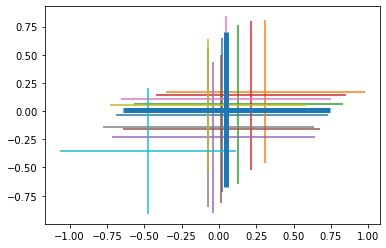

In [438]:
z = cs.sample(1000,X_).detach().numpy()
for i in range(10):
    plt.errorbar(z[:,i,0].mean(0), z[:,i,1].mean(0), xerr=z[:,i,0].std(0), yerr=z[:,i,1].std(0),)
    
plt.errorbar(z[:,:,0].mean((0,1)), z[:,:,1].mean((0,1)), xerr=z[:,:,0].std((0,1)), yerr=z[:,:,1].std((0,1)), lw=5)
